In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
from typing import List, Tuple
from torch.utils.data import Dataset, DataLoader, random_split
from collections import Counter
import re

In [48]:
print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.5.1+cu124


In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

print(f"Using device: {device}")

Using device: cuda


## Text Manager


In [50]:
class NewsDataset(Dataset):
    def __init__(self, texts: List[str], labels: List[int], vocab=None, max_length=100):
        self.texts = texts
        self.labels = labels
        self.max_length = max_length

        if vocab is None:
            self.vocab = self._build_vocab()
        else:
            self.vocab = vocab

    def _build_vocab(self, min_freq: int = 5):
        word_counts = Counter()
        for text in self.texts:
            words = self._tokenize(text)
            word_counts.update(words)

        vocab = {"<PAD>": 0, "<UNK>": 1}
        for word, count in word_counts.items():
            if count >= min_freq:
                vocab[word] = len(vocab)

        return vocab

    def _tokenize(self, text: str) -> List[str]:
        words = re.findall(r"\b\w+\b", text.lower())
        return words

    def _convert_to_ids(self, tokens: List[str]) -> List[int]:
        tokens = tokens[: self.max_length]
        ids = [self.vocab.get(token, self.vocab["<UNK>"]) for token in tokens]

        if len(ids) < self.max_length:
            ids += [self.vocab["<PAD>"]] * (self.max_length - len(ids))

        return ids

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        tokens = self._tokenize(text)
        ids = self._convert_to_ids(tokens)

        return (
            torch.tensor(ids, dtype=torch.long),
            torch.tensor(label, dtype=torch.long),
        )

In [51]:
def load_ag_news(file_path: str) -> Tuple[List[str], List[int]]:
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            first_line = f.readline().strip()
            has_header = first_line.startswith("Class Index") or first_line.startswith(
                "class"
            )

        df = pd.read_csv(
            file_path,
            header=0 if has_header else None,
            names=["label", "title", "description"],
            encoding="utf-8",
        )

        labels = []
        texts = []

        for idx, row in df.iterrows():
            try:
                label = int(str(row["label"]).strip("\"' ")) - 1
                title = str(row["title"]).strip("\"' ")
                description = str(row["description"]).strip("\"' ")
                full_text = f"{title}. {description}"

                labels.append(label)
                texts.append(full_text)
            except Exception as e:
                print(f"Skipping row {idx} due to error: {str(e)}")
                continue

        print(f"Successfully loaded {len(texts)} samples from {file_path}")
        print(f"Label distribution: {Counter(labels)}")

        return texts, labels

    except Exception as e:
        print(f"Error loading file {file_path}: {str(e)}")
        # Show first few lines of the file for debugging
        print("\nFirst few lines of the file:")
        with open(file_path, "r", encoding="utf-8") as f:
            print(f.read(500))
        raise

## Text Classifier


In [52]:
class TextClassifier(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embed_size: int = 300,
        hidden_size: int = 256,
        num_layers: int = 2,
        num_classes: int = 4,
        dropout: float = 0.3,
    ):
        super(TextClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(
            embed_size,
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True,
        )

        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        embedded = self.dropout(self.embedding(x))
        output, hidden = self.gru(embedded)

        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        hidden = self.dropout(hidden)

        return self.fc(hidden)

## Trainer


In [53]:
class Trainer:
    def __init__(
        self,
        model: nn.Module,
        train_loader: DataLoader,
        val_loader: DataLoader,
        test_loader: DataLoader,
        criterion: nn.Module = nn.CrossEntropyLoss(),
        lr: float = 0.001,
        device: torch.device = device,
    ):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.criterion = criterion
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        self.device = device

    def train_epoch(self):
        self.model.train()
        total_loss, correct, total = 0, 0, 0

        for batch in tqdm(self.train_loader, desc="Training", leave=False):
            x, y = [t.to(self.device) for t in batch]

            self.optimizer.zero_grad()
            output = self.model(x)
            loss = self.criterion(output, y)

            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(output, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

        return total_loss / len(self.train_loader), correct / total

    def evaluate(self, loader: DataLoader):
        self.model.eval()
        total_loss, correct, total = 0, 0, 0

        with torch.no_grad():
            for batch in tqdm(loader, desc="Evaluating", leave=False):
                x, y = [t.to(self.device) for t in batch]

                output = self.model(x)
                loss = self.criterion(output, y)

                total_loss += loss.item()
                _, predicted = torch.max(output, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()

        return total_loss / len(loader), correct / total

    def train(self, epochs: int, early_stopping_patience: int = 3):
        best_val_acc, patience_counter = 0, 0
        history = []

        for epoch in range(epochs):
            train_loss, train_acc = self.train_epoch()
            val_loss, val_acc = self.evaluate(self.val_loader)

            history.append(
                {
                    "epoch": epoch + 1,
                    "train_loss": train_loss,
                    "train_acc": train_acc,
                    "val_loss": val_loss,
                    "val_acc": val_acc,
                }
            )

            print(f"\nEpoch {epoch+1}/{epochs}")
            print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
            print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                torch.save(self.model.state_dict(), "best_model.pt")

            else:
                patience_counter += 1

            if patience_counter >= early_stopping_patience:
                print(f"Stopping early. Best Val Acc: {best_val_acc:.4f}")
                break

        self.model.load_state_dict(torch.load("best_model.pt"))
        return history

    def create_confusion_matrix(self, loader: DataLoader = None):
        if loader is None:
            loader = self.test_loader

        self.model.eval()
        all_preds, all_labels = [], []

        with torch.no_grad():
            for batch in loader:
                x, y = [t.to(self.device) for t in batch]
                output = self.model(x)
                _, predicted = torch.max(output, 1)

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(y.cpu().numpy())

        return confusion_matrix(all_labels, all_preds)

## Auxiliary Functions


In [54]:
def plot_training_history(history):
    epochs = [h["epoch"] for h in history]
    metrics = ["loss", "acc"]

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    for idx, metric in enumerate(metrics):
        train_metric = [h[f"train_{metric}"] for h in history]
        val_metric = [h[f"val_{metric}"] for h in history]

        axes[idx].plot(epochs, train_metric, "b-", label=f"Training {metric}")
        axes[idx].plot(epochs, val_metric, "r-", label=f"Validation {metric}")
        axes[idx].set_title(f"{metric.capitalize()} over epochs")
        axes[idx].set_xlabel("Epoch")
        axes[idx].set_ylabel(metric.capitalize())
        axes[idx].legend()
        axes[idx].grid(True)

    plt.tight_layout()
    plt.show()

In [55]:
def plot_confusion_matrix(cm, labels):
    """Plot confusion matrix"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels
    )
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

## Main Execution


In [56]:
train_path = "data/train.csv"
test_path = "data/test.csv"

In [57]:
train_texts, train_labels = load_ag_news(train_path)

Successfully loaded 120000 samples from data/train.csv
Label distribution: Counter({2: 30000, 3: 30000, 1: 30000, 0: 30000})


In [58]:
test_texts, test_labels = load_ag_news(test_path)

Successfully loaded 7600 samples from data/test.csv
Label distribution: Counter({2: 1900, 3: 1900, 1: 1900, 0: 1900})


### Datasets


In [59]:
train_dataset = NewsDataset(train_texts, train_labels)

In [60]:
test_dataset = NewsDataset(test_texts, test_labels, vocab=train_dataset.vocab)

### Data Loaders


In [61]:
BATCH_SIZE = 32
VAL_SPLIT = 0.1

In [62]:
train_size = int((1 - VAL_SPLIT) * len(train_dataset))
val_size = len(train_dataset) - train_size
train_ds, val_ds = random_split(train_dataset, [train_size, val_size])

In [63]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [64]:
print(f"Training samples: {len(train_ds)}")
print(f"Validation samples: {len(val_ds)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 108000
Validation samples: 12000
Test samples: 7600


### Model


In [65]:
VOCAB_SIZE = len(train_dataset.vocab)
EMBED_SIZE = 300
HIDDEN_SIZE = 256
NUM_LAYERS = 2
NUM_CLASSES = 4
DROPOUT = 0.3

In [66]:
model = TextClassifier(
    vocab_size=VOCAB_SIZE,
    embed_size=EMBED_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    num_classes=NUM_CLASSES,
    dropout=DROPOUT,
)

In [67]:
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    lr=0.001,
)

In [68]:
history = trainer.train(epochs=10, early_stopping_patience=3)

Training:   0%|          | 0/3375 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/375 [00:00<?, ?it/s]


Epoch 1/10
Train Loss: 0.4340 | Train Acc: 0.8451
Val Loss: 0.2781 | Val Acc: 0.9028


Training:   0%|          | 0/3375 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/375 [00:00<?, ?it/s]


Epoch 2/10
Train Loss: 0.2571 | Train Acc: 0.9132
Val Loss: 0.2587 | Val Acc: 0.9107


Training:   0%|          | 0/3375 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/375 [00:00<?, ?it/s]


Epoch 3/10
Train Loss: 0.2084 | Train Acc: 0.9297
Val Loss: 0.2416 | Val Acc: 0.9185


Training:   0%|          | 0/3375 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/375 [00:00<?, ?it/s]


Epoch 4/10
Train Loss: 0.1770 | Train Acc: 0.9398
Val Loss: 0.2547 | Val Acc: 0.9172


Training:   0%|          | 0/3375 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/375 [00:00<?, ?it/s]


Epoch 5/10
Train Loss: 0.1586 | Train Acc: 0.9454
Val Loss: 0.2570 | Val Acc: 0.9157


Training:   0%|          | 0/3375 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/375 [00:00<?, ?it/s]


Epoch 6/10
Train Loss: 0.1461 | Train Acc: 0.9495
Val Loss: 0.2821 | Val Acc: 0.9181
Stopping early. Best Val Acc: 0.9185


/tmp/ipykernel_29946/3653158627.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load("best_model.pt"))


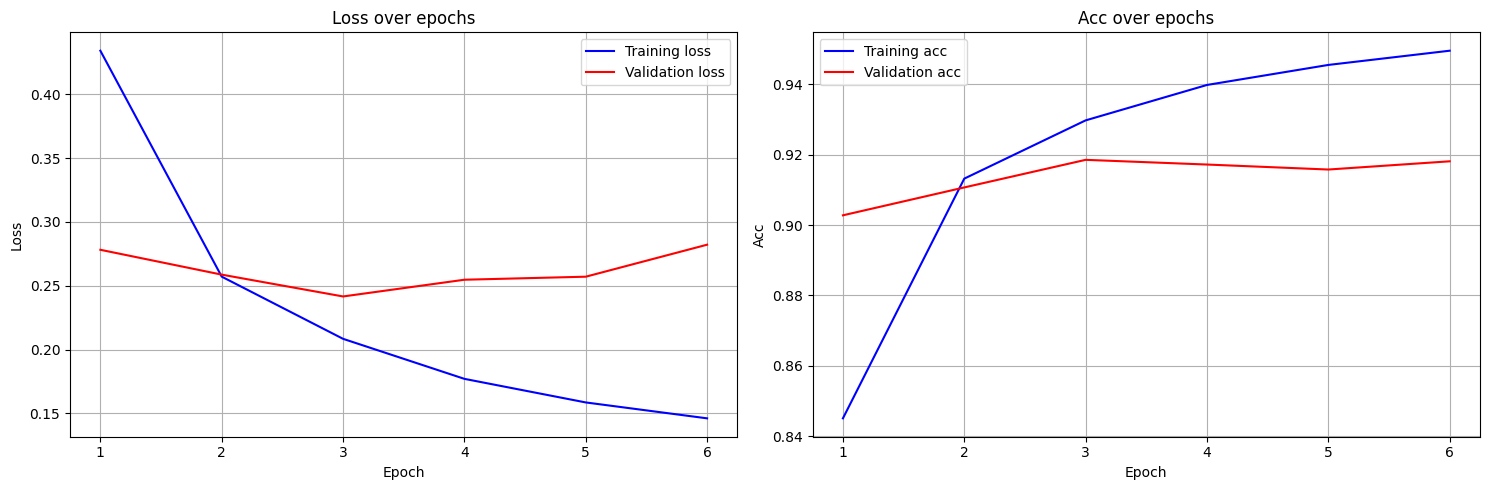

In [69]:
plot_training_history(history)

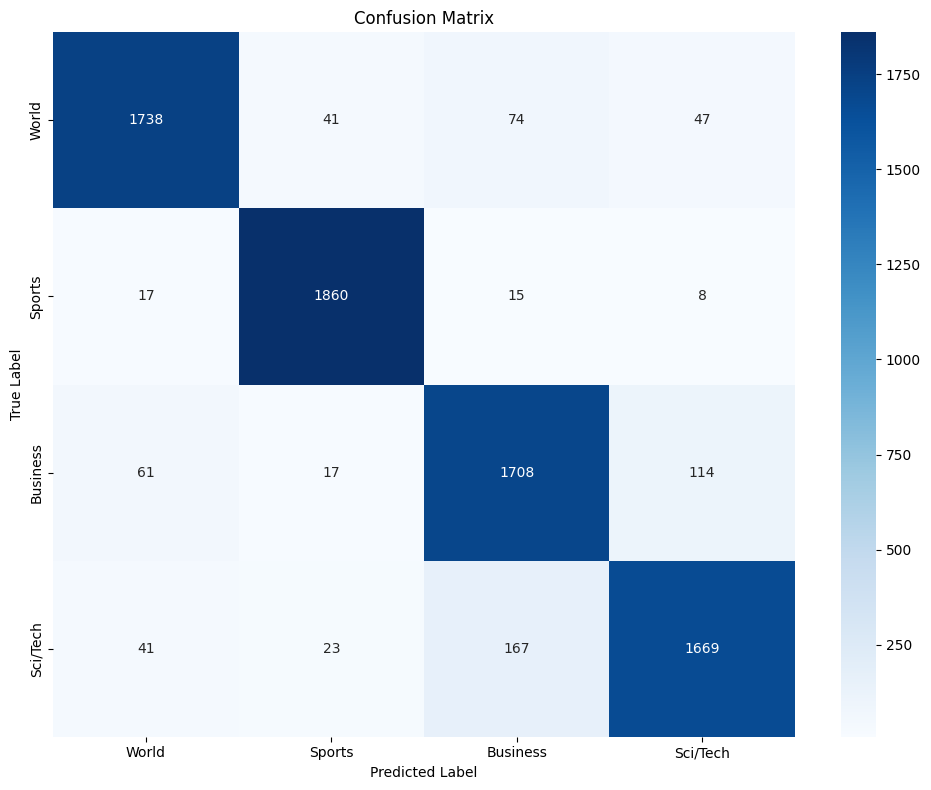

In [70]:
labels = ["World", "Sports", "Business", "Sci/Tech"]
cm = trainer.create_confusion_matrix()

plot_confusion_matrix(cm, labels)

In [71]:
test_loss, test_acc = trainer.evaluate(test_loader)
print(f"\nTest Accuracy: {test_acc:.4f}")

Evaluating:   0%|          | 0/238 [00:00<?, ?it/s]


Test Accuracy: 0.9178


### Text Classification


In [72]:
def classify_text(text: str, model: nn.Module, dataset: NewsDataset):
    model.eval()

    tokens = dataset._tokenize(text)
    ids = dataset._convert_to_ids(tokens)

    x = torch.tensor([ids], dtype=torch.long).to(device)

    with torch.no_grad():
        output = model(x)
        probs = F.softmax(output, dim=1)
        pred_class = torch.argmax(output, dim=1).item()

    return pred_class, probs[0].cpu().numpy()

In [73]:
test_texts = [
    "SpaceX successfully launches rocket to ISS",
    "Manchester United wins Premier League match",
    "Stock market reaches new high",
    "New AI breakthrough in quantum computing",
]

In [74]:
labels = ["World", "Sports", "Business", "Sci/Tech"]

In [75]:
print("\nTesting classification examples:")
for text in test_texts:
    pred_class, probs = classify_text(text, model, train_dataset)

    print(f"\nText: {text}")
    print(f"Predicted class: {labels[pred_class]}")
    print("Class probabilities:")

    for label, prob in zip(labels, probs):
        print(f"{label}: {prob:.4f}")


Testing classification examples:

Text: SpaceX successfully launches rocket to ISS
Predicted class: Sci/Tech
Class probabilities:
World: 0.2880
Sports: 0.0061
Business: 0.0433
Sci/Tech: 0.6626

Text: Manchester United wins Premier League match
Predicted class: Sports
Class probabilities:
World: 0.2612
Sports: 0.7375
Business: 0.0011
Sci/Tech: 0.0002

Text: Stock market reaches new high
Predicted class: Business
Class probabilities:
World: 0.0902
Sports: 0.0024
Business: 0.8786
Sci/Tech: 0.0288

Text: New AI breakthrough in quantum computing
Predicted class: World
Class probabilities:
World: 0.7866
Sports: 0.0026
Business: 0.0585
Sci/Tech: 0.1523
